In [1]:
import warnings
import pandas as pd
import arviz as az
import numpy as np

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, visualize_prior, model_graph, traceplot, plot_gps_components, plot_elbo
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')
import json

import theano
theano.config.compute_test_value='raise'

/home/mach1ne/anaconda3/envs/phd_clean/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


In [2]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [3]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [4]:
single_prediction_length = 24
submission_prediction_length = single_prediction_length * 2
input_path="../data/"
submission=False

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

In [5]:
state_ids = groups['train']['groups_idx']['state']
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)

zone_ids = groups['train']['groups_idx']['zone']
zone_ids_un , zone_ids_counts = np.unique(zone_ids, return_counts=True)

region_ids = groups['train']['groups_idx']['region']
region_ids_un , region_ids_counts = np.unique(region_ids, return_counts=True)

purpose_ids = groups['train']['groups_idx']['purpose']
purpose_ids_un , purpose_ids_counts = np.unique(purpose_ids, return_counts=True)

stat_cat = np.concatenate((state_ids.reshape(-1,1), zone_ids.reshape(-1,1), region_ids.reshape(-1,1), purpose_ids.reshape(-1,1)), axis=1)

stat_cat_cardinalities = [len(state_ids_un), len(zone_ids_un), len(region_ids_un), len(purpose_ids_un)]

In [6]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

tourism_dates = [pd.Timestamp("1998-01-01", freq='1M') for _ in range(data.shape[1])]

In [7]:
groups = generate_groups_data_matrix(groups)

In [8]:
train_target_values = groups['predict']['data'].reshape(groups['train']['s'], groups['predict']['n'])

In [9]:
test_target_values = train_target_values.copy()
train_target_values = [ts[:-single_prediction_length] for ts in test_target_values]

In [10]:
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fsc) in zip(train_target_values,
                                         tourism_dates,
                                         stat_cat)
], freq="M")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fsc) in zip(test_target_values,
                                         tourism_dates,
                                         stat_cat)
], freq="M")

In [11]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="M",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=100,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:02<00:00, 17.17it/s, epoch=72/100, avg_epoch_loss=4.02]

Early stopping based on learning rate scheduler callback (min_lr was reached).


In [12]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/304 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/304 [00:00<?, ?it/s]

In [13]:
if submission == False:
    
    from gluonts.evaluation import Evaluator
    
    class M5Evaluator(Evaluator):
        
        def get_metrics_per_ts(self, time_series, forecast):
            successive_diff = np.diff(time_series.values.reshape(len(time_series)))
            successive_diff = successive_diff ** 2
            successive_diff = successive_diff[:-prediction_length]
            denom = np.mean(successive_diff)
            pred_values = forecast.samples.mean(axis=0)
            true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
            num = np.mean((pred_values - true_values)**2)
            rmsse = num / denom
            metrics = super().get_metrics_per_ts(time_series, forecast)
            metrics["RMSSE"] = rmsse
            return metrics
        
        def get_aggregate_metrics(self, metric_per_ts):
            wrmsse = metric_per_ts["RMSSE"].mean()
            agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
            agg_metric["MRMSSE"] = wrmsse
            return agg_metric, metric_per_ts
        
    
    evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 304/304 [00:00<00:00, 5099.87it/s]


{
    "MSE": 4381.688778044574,
    "abs_error": 231745.0,
    "abs_target_sum": 642729.0,
    "abs_target_mean": 88.09333881578948,
    "seasonal_error": 35.23029742324561,
    "MASE": 0.9028852895843794,
    "MAPE": 0.7950759169809429,
    "sMAPE": 0.9028717211215564,
    "MSIS": 9.13694211810594,
    "QuantileLoss[0.5]": 231745.0,
    "Coverage[0.5]": 0.3245614035087719,
    "QuantileLoss[0.67]": 235060.92,
    "Coverage[0.67]": 0.5383771929824562,
    "QuantileLoss[0.95]": 102418.00000000003,
    "Coverage[0.95]": 0.9170778508771928,
    "QuantileLoss[0.99]": 44829.22000000001,
    "Coverage[0.99]": 0.9646381578947368,
    "RMSE": 66.19432587499153,
    "NRMSE": 0.7514112504398249,
    "ND": 0.36056409466509215,
    "wQuantileLoss[0.5]": 0.36056409466509215,
    "wQuantileLoss[0.67]": 0.3657232208286852,
    "wQuantileLoss[0.95]": 0.15934865238693138,
    "wQuantileLoss[0.99]": 0.06974824537246647,
    "mean_absolute_QuantileLoss": 153513.285,
    "mean_wQuantileLoss": 0.2388460533

In [14]:
def mase(n,seas,h,y,f):
    return np.mean(((n-seas)/h
            * (np.sum(np.abs(y[n:n+h,:] - f), axis=0)
               / np.sum(np.abs(y[seas:n, :] - y[:n-seas, :]), axis=0))))


In [15]:
def generate_groups_data_matrix(groups):

    for group in groups['train']['groups_idx'].keys():
        groups['train']['groups_idx'][group] = groups['train']['groups_idx'][group].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
        groups['predict']['groups_idx'][group] = groups['predict']['groups_idx'][group].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    groups['train']['full_data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T
    groups['train']['data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T

    groups['train']['n_series_idx_full'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
    groups['train']['n_series_idx'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]

    groups['predict']['n_series_idx'] = groups['predict']['n_series_idx'].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    return groups

In [16]:
def calculate_metrics(pred_samples,
                      groups):

    pred_s0 = pred_samples.shape[0]
    pred_s1 = pred_samples.shape[1]
    pred_s2 = pred_samples.shape[2]

    pred_samples = pred_samples.reshape(pred_s0, pred_s1*pred_s2, order='F')

    seasonality = groups['seasonality']
    h = groups['h']
    
    n = groups['predict']['n']
    s = groups['predict']['s']
    y_f = groups['predict']['data'].reshape(s, n).T
    y_all_g = {}
    f_all_g = {}
    
    mase_ = {}
    rmse_ = {}
    
    # Bottom
    y_all_g['bottom'] = y_f
    f_all_g['bottom'] = np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]
    
    mase_['bottom'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_f, 
                                     f=np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]),3)
    rmse_['bottom'] = np.round(mean_squared_error(y_f[n-h:n,:], np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], squared=False), 3)

    # Total
    y_all_g['total'] = np.sum(y_f, axis=1).reshape(-1,1)
    f_all_g['total'] = np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1)
    
    mase_['total'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=np.sum(y_f, axis=1).reshape(-1,1), 
                                     f=np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1))
                            ,3)
    rmse_['total'] = np.round(mean_squared_error(np.sum(y_f, axis=1).reshape(-1,1)[n-h:n,:], 
                                             np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:],axis=1).reshape(-1,1), 
                                             squared=False), 3)

    # Groups
    idx_dict_new = {}
    for group in list(groups['predict']['groups_names'].keys()):
        y_g = np.zeros((groups['predict']['n'], groups['predict']['groups_names'][group].shape[0]))
        f_g = np.zeros((h, groups['predict']['groups_names'][group].shape[0]))

        for idx, name in enumerate(groups['predict']['groups_names'][group]):               

            g_n = groups['predict']['groups_n'][group]

            idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

            y_g[:,idx] = np.sum(idx_dict_new[name]*y_f, axis=1)
            f_g[:,idx] = np.sum(idx_dict_new[name]*np.mean(pred_samples, axis=0).reshape(s, n).T, axis=1)[n-h:n]

        y_all_g[group] = np.sum(y_g, axis=1).reshape(-1,1)
        f_all_g[group] = np.sum(f_g, axis=1).reshape(-1,1)

        mase_[group] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_g, 
                                     f=f_g)
                                ,3)

        rmse_[group] = np.round(mean_squared_error(y_g[n-h:n,:], f_g, squared=False), 3)

    # All
    y_all = np.concatenate([y_all_g[x] for x in y_all_g], 1)
    f_all = np.concatenate([f_all_g[x] for x in f_all_g], 1)

    mase_['all'] = np.round(mase(n=n-h, 
                         seas=seasonality, 
                         h=h, 
                         y=y_all, 
                         f=f_all),3)
    rmse_['all'] = np.round(mean_squared_error(y_all[n-h:n,:], f_all, squared=False), 3)
    
    results = {}
    results['mase'] = mase_
    results['rmse'] = rmse_
    return results

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

def visualize_fit(groups, pred_samples_fit, n_series_to_show):
    assert n_series_to_show%2 == 0, "'n_series_to_show' must be an integer even number"
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    n = groups['train']['n']
    ax = np.ravel(ax)
    for i in range(n_series_to_show):
        ax[i].plot(np.arange(n), pred_samples_fit[:,:,i].T, alpha=0.003, color='orange', label='model fit')
        ax[i].plot(np.arange(n), groups['train']['data'][:,i], label='data')

def visualize_predict(groups, pred_samples_predict, n_bottom_series_to_show, levels=[0,1,2]):
    """
    Parameters
    ----------
    levels: list
                0 -> total, 1 -> groups, 2 -> bottom
                Default to [0,1,2]
    """
    n_series_to_show = n_bottom_series_to_show
    if 0 in levels:
        n_series_to_show += 1 
    if 1 in levels:
        for _,k in groups['predict']['groups_n'].items():
            n_series_to_show += 2 # only show two series of each group aggregate
            
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)
    n = groups['train']['n']
    n_new = groups['predict']['n']
    j = 0
    # Total
    if 0 in levels:
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        y_all_g = np.sum(y_f, axis=1).reshape(-1,1)

        ax[j].fill_between(np.arange(n_new), 
                        np.percentile(np.sum(pred_samples_predict, axis=2).T, axis=1, q=2.5),
                        np.percentile(np.sum(pred_samples_predict, axis=2).T, axis=1, q=97.5),
                        label='95% CI', alpha=0.1)
        ax[j].plot(np.arange(n_new), 
                np.median(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='tab:blue', alpha=0.7, label='median')
        ax[j].plot(np.arange(n_new), 
                np.mean(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='b', label='mean')
        ax[j].set_ylim(0,max(np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)*1.5))
        ax[j].plot(np.sum(groups['train']['full_data'], axis=1), 
                color='darkorange', label='training data')
        ax[j].plot(np.arange(n, n_new),
                np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)[n:],
                color='r', label='forecasting data')
        ax[j].legend()
        ax[j].set_title('Total: sum of all series')
        j+=1
    if 1 in levels:
        idx_dict_new = {}
        y_all_g = {}
        f_all_g = {}
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        for id_group, group in enumerate(list(groups['predict']['groups_names'].keys())):
            y_g = np.zeros((groups['predict']['n'], 1))
            f_g = np.zeros((500, groups['predict']['groups_names'][group].shape[0]))
                
            y_all_g[group] = {}
            f_all_g[group] = {}
            
            for idx, name in enumerate(groups['predict']['groups_names'][group]):               
                # Only show 2 plots of each group -> change this is to show more
                if idx < 2:
                    g_n = groups['predict']['groups_n'][group]

                    idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

                    y_g = np.sum(idx_dict_new[name].reshape(1,-1)*y_f, axis=1)
                    f_g = np.sum(idx_dict_new[name].reshape(1,-1)*pred_samples_predict, axis=(2))
                    
                    y_all_g[group][name] = y_g
                    f_all_g[group][name] = f_g
                    
                    ax[j].fill_between(np.arange(groups['predict']['n']), 
                                    np.percentile(f_all_g[group][name], axis=0, q=2.5),
                                    np.percentile(f_all_g[group][name], axis=0, q=97.5),
                                    label='95% CI', alpha=0.1)
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.median(f_all_g[group][name], axis=0),
                            color='tab:blue', alpha=0.7, label='median')
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.mean(f_all_g[group][name], axis=0),
                            color='b', label='mean')
                    ax[j].set_ylim(0,max(y_all_g[group][name])*1.5)
                    ax[j].plot(y_all_g[group][name][:groups['train']['n']], 
                            color='darkorange', label='training data')
                    ax[j].plot(np.arange(groups['train']['n'], groups['predict']['n']),
                            y_all_g[group][name][groups['train']['n']:],
                            color='r', label='forecasting data')
                    ax[j].legend()
                    ax[j].set_title(f'Group {group}: {name}')
                    
                    j+=1
    if 2 in levels:
        for i in range(n_bottom_series_to_show-1):
            ax[j].fill_between(np.arange(n_new), 
                            np.percentile(pred_samples_predict[:,:,i], axis=0, q=2.5),
                            np.percentile(pred_samples_predict[:,:,i], axis=0, q=97.5),
                            label='95% CI', alpha=0.1)
            ax[j].plot(np.arange(n_new), np.median(pred_samples_predict[:,:,i], axis=0), color='tab:blue', alpha=0.7, label='median')
            ax[j].plot(np.arange(n_new), np.mean(pred_samples_predict[:,:,i], axis=0), color='b', label='mean')
            ax[j].set_ylim(0,max(groups['predict']['data'][i*n_new:i*n_new+n_new])*1.5)
            ax[j].plot(groups['train']['full_data'][:,i], color='darkorange', label='training data')
            ax[j].plot(np.arange(n, n_new), groups['predict']['data'][i*n_new+n:i*n_new+n_new], color='r', label='forecasting data')
            ax[j].legend()
            ax[j].set_title(f'Series {i}',)
            j+=1

def traceplot(trace):
    return pm.traceplot(trace, var_names=['~f_'], filter_vars="like")

def model_graph(model):
    return pm.model_graph.model_to_graphviz(model)

def visualize_prior(groups, prior_checks, n_series_to_show):

    assert n_series_to_show%2 == 0, "'n_series_to_show' must be an integer even number"

    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)

    for i in range(n_series_to_show):
        ax[i].plot(prior_checks['prior_like'][:,:,i].T, color='b', alpha=0.1)
        ax[i].plot(groups['train']['data'][:,i], color='darkorange')
        ax[i].set_ylim(min(min(groups['train']['data'][:,i])*5,0), max(groups['train']['data'][:,i])*5)

def plot_elbo(trace, last_it=80000):
    plt.plot(-trace.hist[-last_it:])
    plt.title(f'ELBO of the last {last_it} iterations')

def plot_gps_components(series, groups, trace):
    g_idx = [g_idx[series] for g_idx in list(groups['predict']['groups_idx'].values())]

    names_g  = [names[g_idx] for g_idx, names in zip(g_idx, list(groups['train']['groups_names'].values()))]

    _, ax = plt.subplots(groups['train']['g_number']+2, 1, figsize=(20, 20))

    ax = ax.ravel()

    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
            'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey',
            'tab:olive']
    ax[0].set_title(f'Sum of all GPs for series {series}, represented by groups {names_g}')

    trace_vi = []
    for i in range(groups['train']['g_number']):
        trace_vi.append(trace[f'f_{names_g[i]}'].T)
    trace_vi = np.asarray(trace_vi)

    sum_gps = np.sum(trace_vi, axis=0)
    ax[0].plot(sum_gps, color='black', alpha=0.1)
    ax[0].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

    ax[1].set_title('Stacked representation of the sum of the GPs')
    ax[1].stackplot(np.arange(trace_vi.shape[1]), np.mean(trace_vi, axis=2), colors=color)
    ax[1].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

    for i in range(groups['train']['g_number']):
        ax[i+2].plot(trace_vi[i,:,:], color=color[i], alpha=0.1)
        group = list(groups['train']['groups_names'].keys())[i]
        ax[i+2].set_title(f'GP for {group} {names_g[i]}')
        ax[i+2].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

In [18]:
len(forecasts)

304

In [19]:
res =np.zeros((len(forecasts), 100, 24))
for i, j in enumerate(forecasts):
    res[i] = j.samples

In [20]:
res = np.concatenate((np.zeros((304, 100, 204), dtype=np.float64), res), axis=2)

In [21]:
res = np.transpose(res, (1, 2, 0))

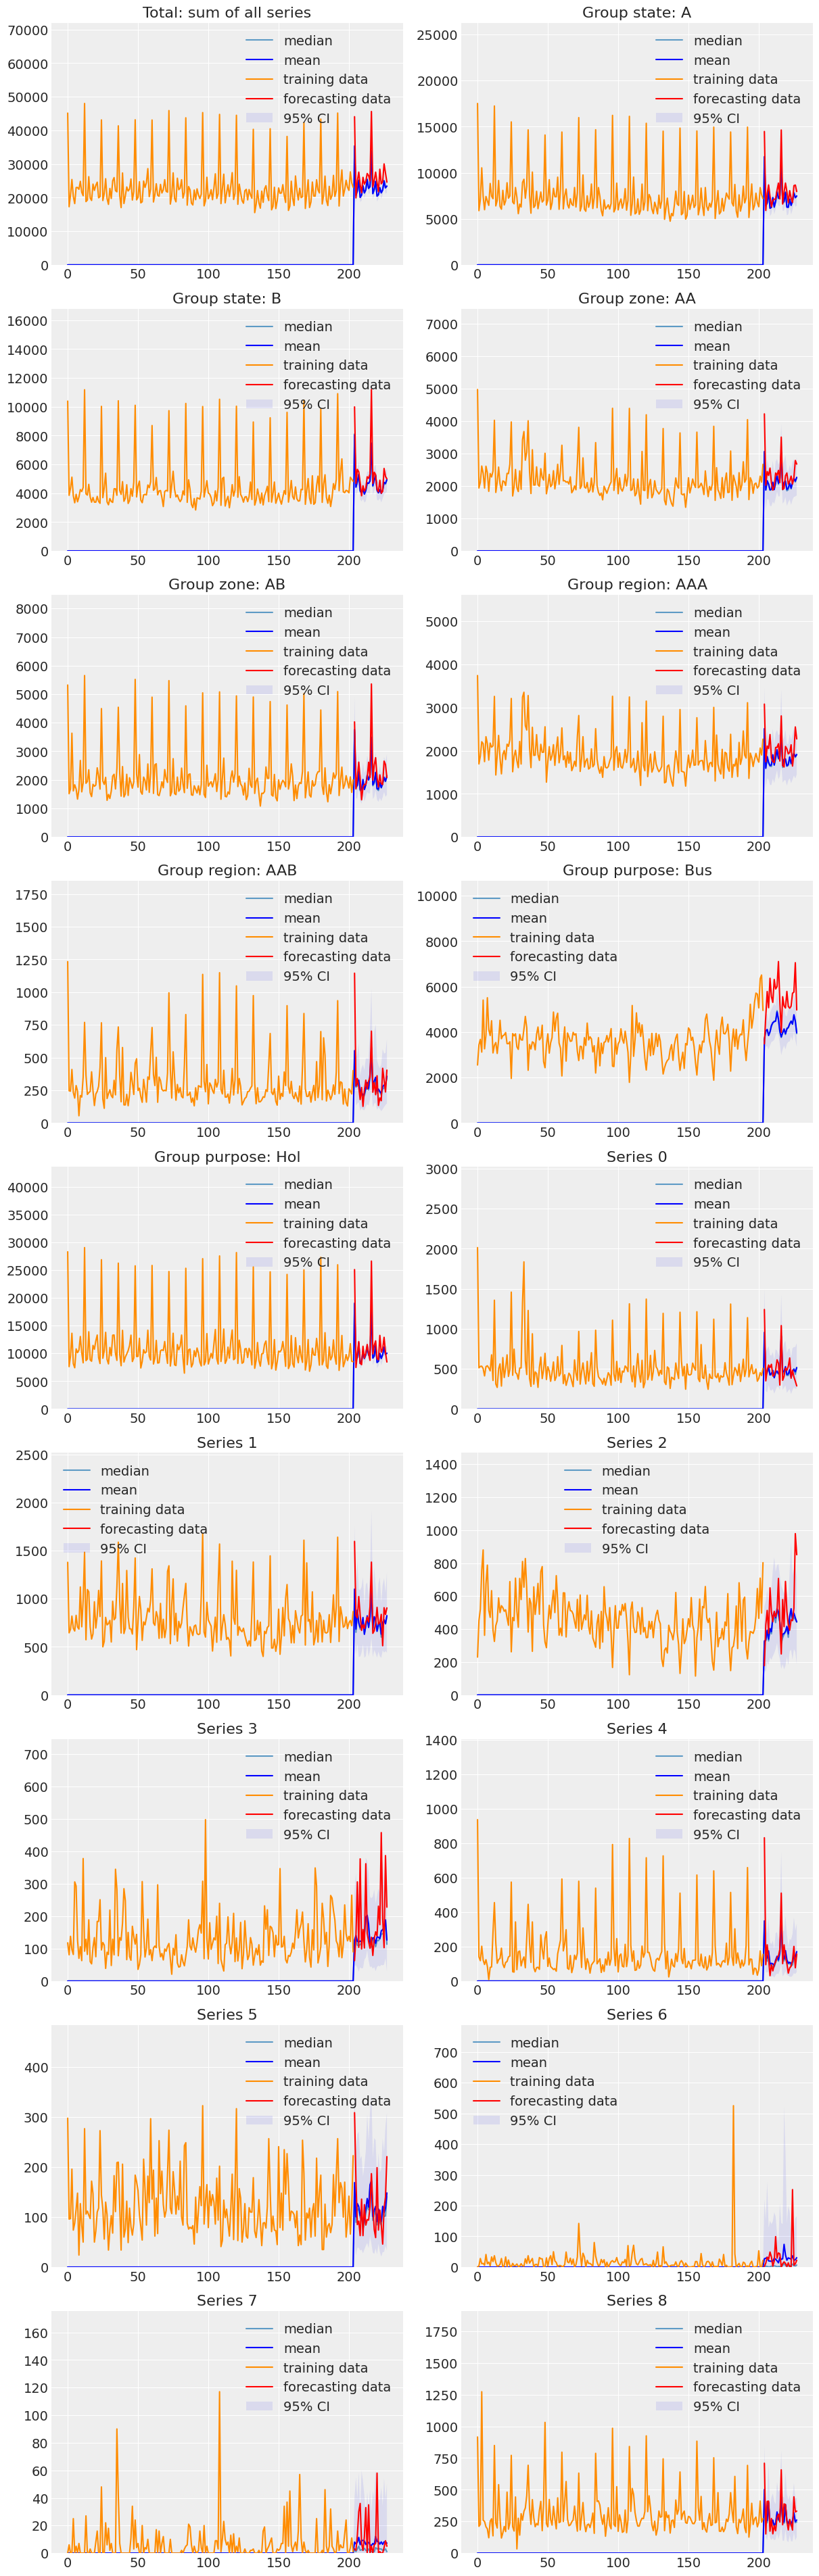

In [22]:
visualize_predict(groups, res, 10)

In [23]:
from sklearn.metrics import mean_squared_error

results = calculate_metrics(res, groups)
metrics_to_table(results)

,bottom,total,state,zone,region,purpose,all
mase,1.007,2.072,1.365,1.062,0.937,1.483,1.025
rmse,45.16,4132.957,723.825,241.242,111.171,1335.261,111.306


Plotting time series predictions ...


  0%|          | 0/5 [00:00<?, ?it/s]

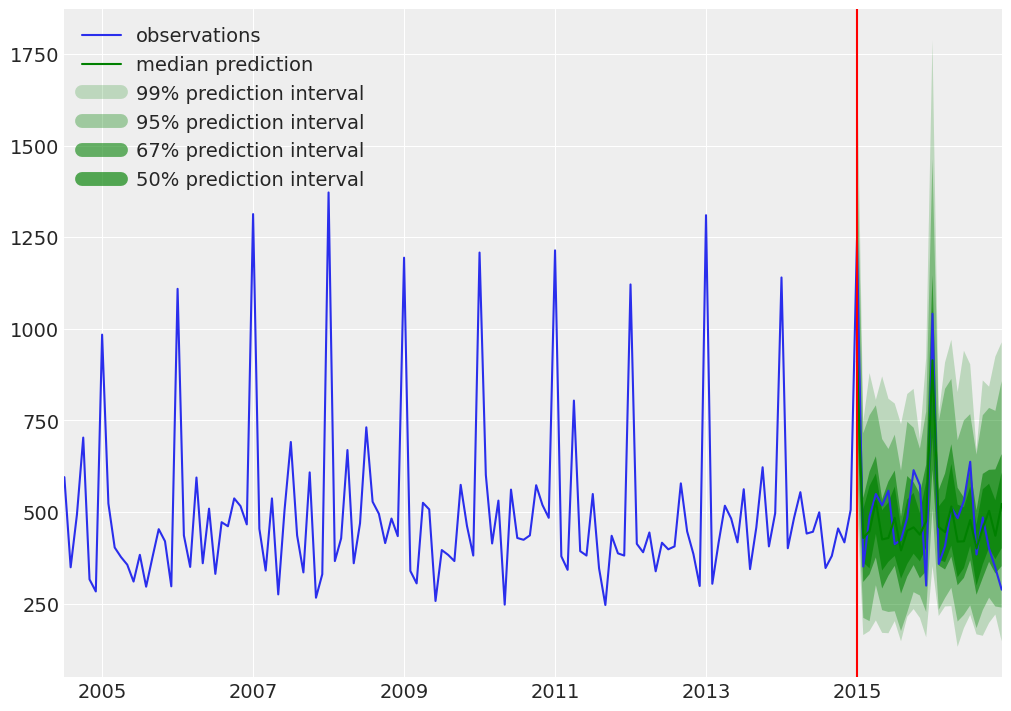

<Figure size 720x480 with 0 Axes>

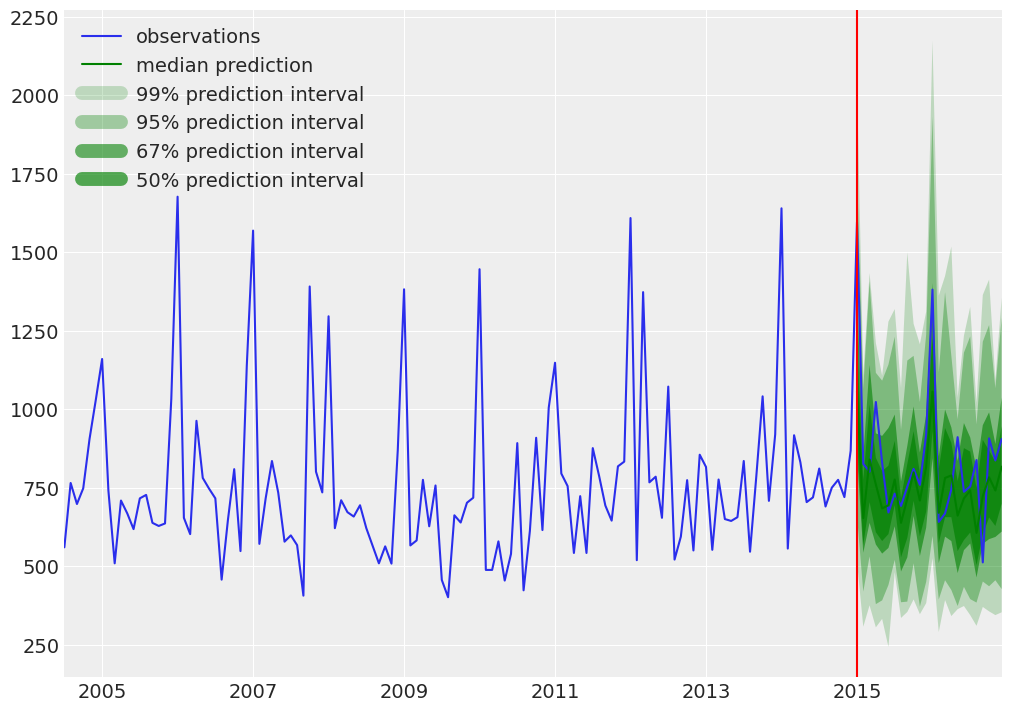

<Figure size 720x480 with 0 Axes>

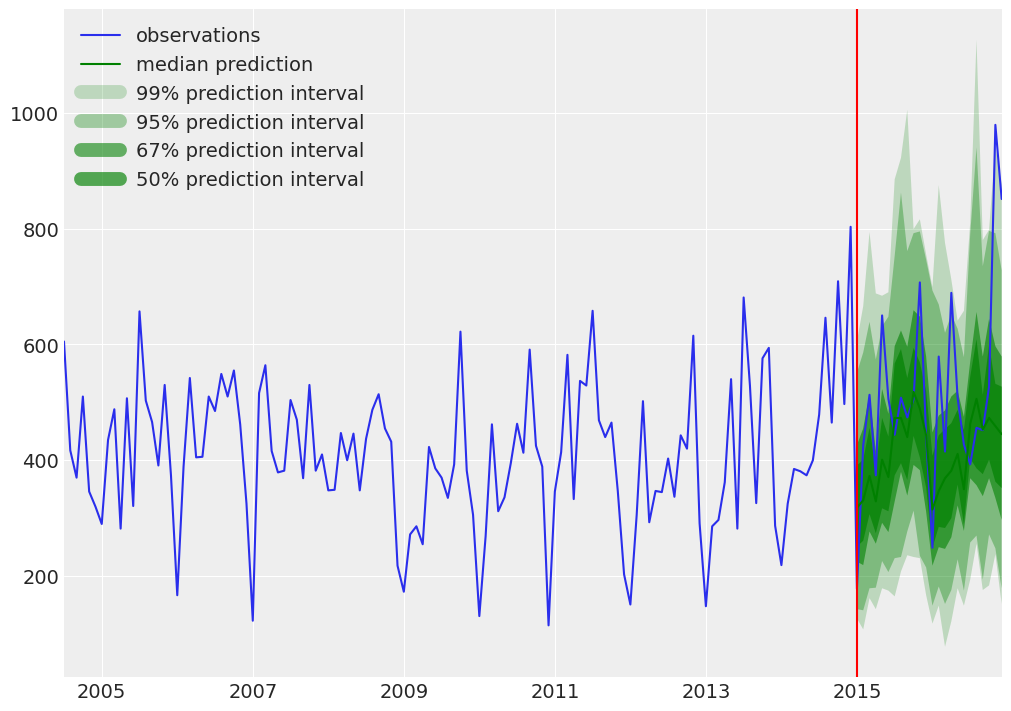

<Figure size 720x480 with 0 Axes>

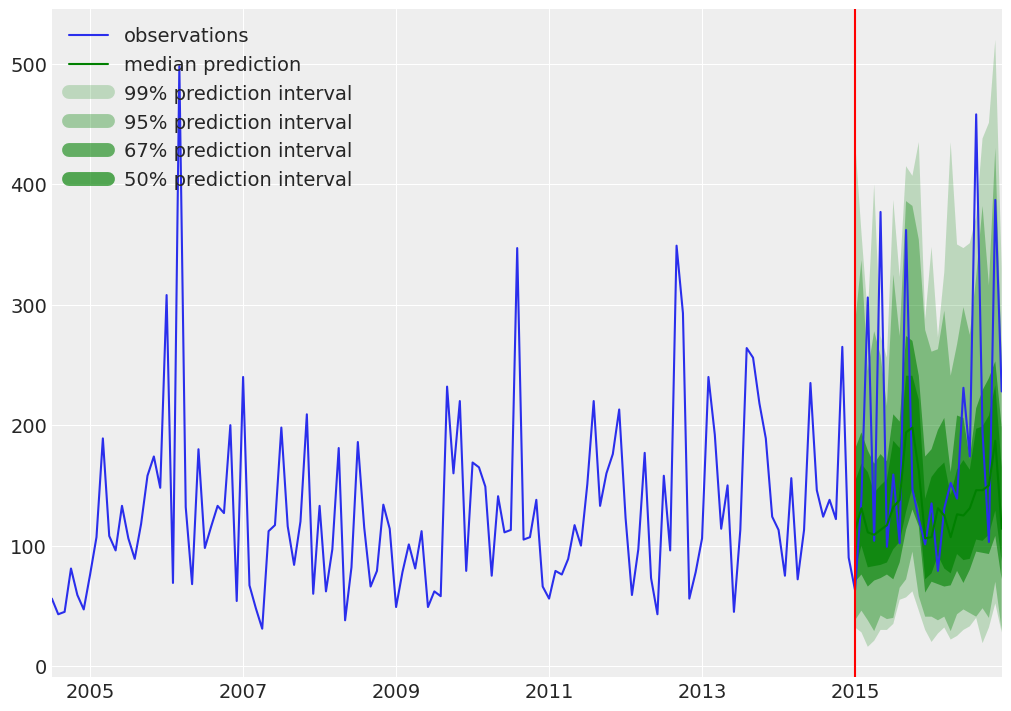

<Figure size 720x480 with 0 Axes>

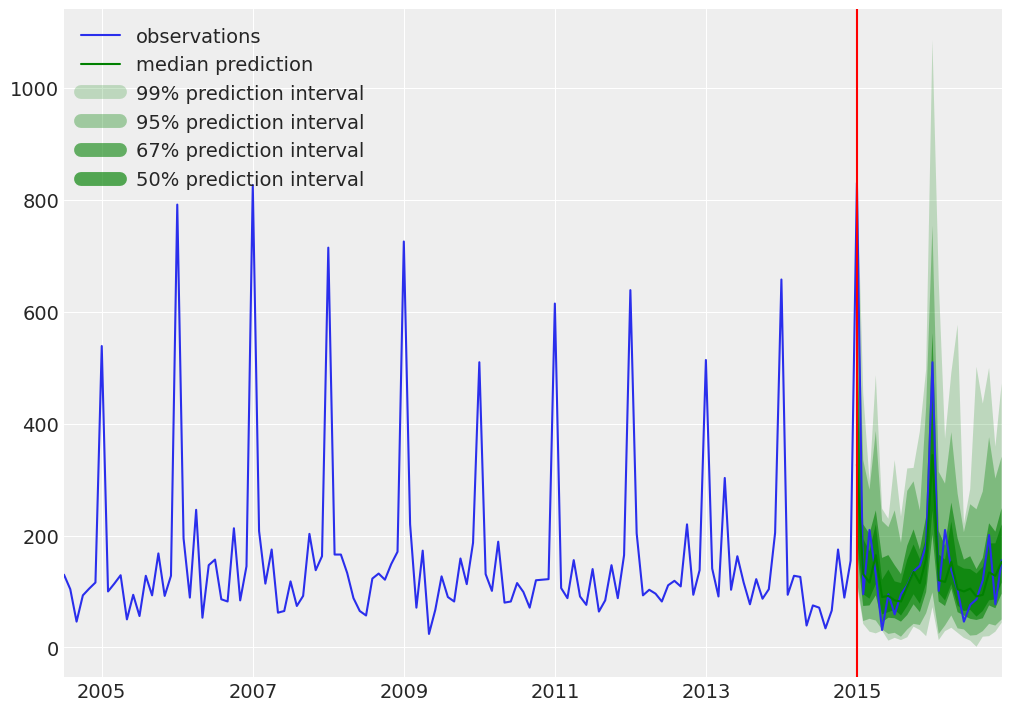

<Figure size 720x480 with 0 Axes>

In [24]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)
    